In [1]:
import requests
import pandas as pd

API_KEY = 'RqDy60O7DAKhvOBhy+dgnxKYpxIS6RmDUzU7eY6W2rOTg6S7E1pqNRfIaEFGS865'

headers = {
    'Authorization': f'Bearer {API_KEY}',
    'Accept': 'application/json'
}

base_url = 'https://api.collegefootballdata.com'
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'

# Pull 2025 regular season games
response = requests.get(
    f'{base_url}/games',
    headers=headers,
    params={'year': 2025, 'seasonType': 'regular'}
)

games = response.json()
df_games = pd.DataFrame(games)
df_games.to_csv(f'{data_path}\\cfb_games_2025.csv', index=False)

print(f"Games pulled: {len(df_games)}")
print(f"Columns: {df_games.columns.tolist()}")
print(df_games.head())

Games pulled: 3745
Columns: ['id', 'season', 'week', 'seasonType', 'startDate', 'startTimeTBD', 'completed', 'neutralSite', 'conferenceGame', 'attendance', 'venueId', 'venue', 'homeId', 'homeTeam', 'homeClassification', 'homeConference', 'homePoints', 'homeLineScores', 'homePostgameWinProbability', 'homePregameElo', 'homePostgameElo', 'awayId', 'awayTeam', 'awayClassification', 'awayConference', 'awayPoints', 'awayLineScores', 'awayPostgameWinProbability', 'awayPregameElo', 'awayPostgameElo', 'excitementIndex', 'highlights', 'notes']
          id  season  week seasonType                 startDate  startTimeTBD  \
0  401756846    2025     1    regular  2025-08-23T16:00:00.000Z         False   
1  401767476    2025     1    regular  2025-08-23T17:00:00.000Z         False   
2  401760371    2025     1    regular  2025-08-23T20:00:00.000Z         False   
3  401767126    2025     1    regular  2025-08-23T20:30:00.000Z         False   
4  401756847    2025     1    regular  2025-08-23T22:30

In [10]:
import pandas as pd
import numpy as np

data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'

# Load data
df = pd.read_csv(f'{data_path}\\cfb_games_2025.csv')

# Filter to completed games where at least one team is FBS or FCS
df = df[
    (df['completed'] == True) & 
    (df['homeClassification'].isin(['fbs', 'fcs'])) & 
    (df['awayClassification'].isin(['fbs', 'fcs']))
].copy()
print(f"FBS vs FBS completed games: {len(df)}")

# Calculate margin from home team perspective
df['home_margin'] = df['homePoints'] - df['awayPoints']

# Get unique teams
teams = sorted(set(df['homeTeam'].unique()) | set(df['awayTeam'].unique()))
n_teams = len(teams)
print(f"FBS Teams: {n_teams}")

# Build game list for each team: (opponent, margin, is_home, is_neutral)
team_games = {team: [] for team in teams}

for _, game in df.iterrows():
    home = game['homeTeam']
    away = game['awayTeam']
    margin = game['home_margin']
    neutral = game['neutralSite']
    
    team_games[home].append({'opponent': away, 'margin': margin, 'is_home': True, 'neutral': neutral})
    team_games[away].append({'opponent': home, 'margin': -margin, 'is_home': False, 'neutral': neutral})

# Step 1: Calculate raw average MOV for each team
avg_mov = {}
for team in teams:
    margins = [g['margin'] for g in team_games[team]]
    avg_mov[team] = np.mean(margins) if margins else 0

# Step 2: Estimate HFA from home vs away performance
home_margins = []
for team in teams:
    home_games = [g['margin'] for g in team_games[team] if g['is_home'] and not g['neutral']]
    away_games = [g['margin'] for g in team_games[team] if not g['is_home'] and not g['neutral']]
    
    if home_games and away_games:
        home_margins.append(np.mean(home_games) - np.mean(away_games))

hfa = np.mean(home_margins) / 2  # Divide by 2 because home-away diff captures 2x HFA
print(f"\nEstimated Home Field Advantage: {hfa:.2f} points")

# Step 3: Calculate HFA-adjusted margins
team_adj_margins = {team: [] for team in teams}
for team in teams:
    for g in team_games[team]:
        if g['neutral']:
            adj_margin = g['margin']
        elif g['is_home']:
            adj_margin = g['margin'] - hfa  # Remove home advantage
        else:
            adj_margin = g['margin'] + hfa  # Remove away disadvantage
        team_adj_margins[team].append({'opponent': g['opponent'], 'adj_margin': adj_margin})

# Step 4: Iterative SRS calculation
srs = {team: np.mean([g['adj_margin'] for g in team_adj_margins[team]]) for team in teams}

for iteration in range(100):
    new_srs = {}
    for team in teams:
        games = team_adj_margins[team]
        avg_adj_margin = np.mean([g['adj_margin'] for g in games])
        avg_opp_srs = np.mean([srs[g['opponent']] for g in games])
        new_srs[team] = avg_adj_margin + avg_opp_srs
    
    # Check convergence
    max_change = max(abs(new_srs[t] - srs[t]) for t in teams)
    srs = new_srs
    
    if max_change < 0.001:
        print(f"Converged after {iteration + 1} iterations")
        break

# Normalize so average = 0
mean_srs = np.mean(list(srs.values()))
srs = {team: rating - mean_srs for team, rating in srs.items()}

# Create results dataframe
results = pd.DataFrame({
    'team': list(srs.keys()),
    'srs_rating': list(srs.values())
})
results = results.sort_values('srs_rating', ascending=False).reset_index(drop=True)
results['srs_rank'] = range(1, len(results) + 1)

# Add average MOV for reference
results['avg_mov'] = results['team'].map(avg_mov)

# Calculate Strength of Schedule (SOS) = average opponent SRS
sos = {}
for team in teams:
    opponents = [g['opponent'] for g in team_adj_margins[team]]
    sos[team] = np.mean([srs[opp] for opp in opponents])

results['sos'] = results['team'].map(sos)
results['sos_rank'] = results['sos'].rank(ascending=False).astype(int)

print(f"\nTop 25 by SRS:")
print(results[['srs_rank', 'team', 'srs_rating', 'avg_mov', 'sos', 'sos_rank']].head(25).to_string(index=False))

# Save
results.to_csv(f'{data_path}\\cfb_srs_2025.csv', index=False)
print(f"\nSaved to cfb_srs_2025.csv")

FBS vs FBS completed games: 1570
FBS Teams: 265

Estimated Home Field Advantage: 5.99 points
Converged after 65 iterations

Top 25 by SRS:
 srs_rank          team  srs_rating   avg_mov       sos  sos_rank
        1       Indiana   49.828990 31.076923 19.674303        18
        2    Ohio State   44.888671 26.769231 19.041725        30
        3        Oregon   43.938894 23.333333 21.604635         5
        4    Texas Tech   43.104827 31.538462 12.488658        66
        5    Notre Dame   42.134407 24.416667 18.716855        31
        6          Utah   38.781906 22.416667 16.365440        45
        7         Miami   35.410742 20.250000 17.158773        39
        8           USC   34.003919 14.083333 20.919703        11
        9       Georgia   33.339718 16.000000 19.184064        24
       10       Alabama   32.949674 13.846154 20.025782        15
       11    Vanderbilt   32.726870 17.500000 16.225977        46
       12           BYU   32.527187 12.923077 19.604321        19
   

In [69]:
# =============================================================================
# ELO-BASED POWER RATINGS: TWO-PASS "BULLY FILTER" + HYBRID DOMINANCE + ETL
# =============================================================================
import pandas as pd
import numpy as np
import os
# Define Path (User Local)
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'
games_out = f'{data_path}\\cfb_games_2025_enriched.csv'
teams_out = f'{data_path}\\cfb_elo_rankings_2025.csv'
# 1. LOAD DATA
try:
    df = pd.read_csv(f'{data_path}\\cfb_games_2025.csv')
   
    # Filter to completed FBS/FCS games with excitement index
    df = df[
        (df['completed'] == True) &
        (df['homeClassification'].isin(['fbs', 'fcs'])) &
        (df['awayClassification'].isin(['fbs', 'fcs'])) &
        (df['excitementIndex'].notna())
    ].copy()
   
    # Date sort for consistency
    if 'startDate' in df.columns:
        df['startDate'] = pd.to_datetime(df['startDate'])
        df = df.sort_values('startDate').reset_index(drop=True)
    print(f"Data Loaded: {len(df)} games.")
except NameError:
    print("Error: Could not load data. Ensure 'data_path' is correct.")
except FileNotFoundError:
    print(f"Error: File not found at {data_path}")
# 2. DEFINE HYBRID DOMINANCE (OPTIMIZED PARAMS)
# Constants from optimization
K_EXC, X0_EXC = 0.1844, 20.00
K_MOV, X0_MOV = 0.2219, 2.60
K_MIX, X0_MIX = 0.1096, 24.80
ELO_DIVISOR = 400.0
def calculate_hybrid_dominance(row):
    exc = row['excitementIndex'] if pd.notna(row['excitementIndex']) else 6.0
    mov = abs(row['homePoints'] - row['awayPoints'])
   
    dom_exc = 1 / (1 + np.exp(K_EXC * (exc - X0_EXC)))
    dom_mov = 1 / (1 + np.exp(-K_MOV * (mov - X0_MOV)))
    weight_exc = 1 / (1 + np.exp(K_MIX * (mov - X0_MIX)))
   
    return (weight_exc * dom_exc) + ((1 - weight_exc) * dom_mov)
# Apply Dominance
df['dominance'] = df.apply(calculate_hybrid_dominance, axis=1)
# Diagnostic
mov_raw = (df['homePoints'] - df['awayPoints']).abs()
print(f"Hybrid Dominance Correlation with MOV: {df['dominance'].corr(mov_raw):.3f}")
# Get unique teams
teams = sorted(set(df['homeTeam'].unique()) | set(df['awayTeam'].unique()))
# =============================================================================
# 3. PASS 1: PRE-FLIGHT ELO (To Identify Team Strength)
# =============================================================================
# Build initial standard game list
print("Building Pre-Flight Game Lists...")
pre_games = {team: [] for team in teams}
for _, game in df.iterrows():
    home = game['homeTeam']
    away = game['awayTeam']
    home_win = game['homePoints'] > game['awayPoints']
    dom = game['dominance']
    neutral = game['neutralSite']
   
    # Calculate Actual Score
    if home_win:
        home_act = 0.5 + 0.5 * dom
        away_act = 0.5 - 0.5 * dom
    else:
        home_act = 0.5 - 0.5 * dom
        away_act = 0.5 + 0.5 * dom
       
    pre_games[home].append({'opp': away, 'act': home_act, 'is_home': True, 'neut': neutral})
    pre_games[away].append({'opp': home, 'act': away_act, 'is_home': False, 'neut': neutral})
# Calculate HFA (Base) - THIS IS THE CRITICAL FIX (Calculated BEFORE filtering)
home_acts = [g['act'] for t in teams for g in pre_games[t] if g['is_home'] and not g['neut']]
avg_home = np.mean(home_acts)
HFA = -ELO_DIVISOR * np.log10((1 - avg_home) / avg_home)
print(f"Estimated HFA: {HFA:.1f}")
# Run Pre-Flight Iteration
pre_elo = {team: 1500.0 for team in teams}
for i in range(50): # 50 iterations for rough convergence
    new_elo = {}
    for team in teams:
        if not pre_games[team]:
            new_elo[team] = 1500.0
            continue
        implied = []
        for g in pre_games[team]:
            opp_r = pre_elo[g['opp']]
            if g['neut']: adj = 0
            elif g['is_home']: adj = -HFA
            else: adj = HFA
           
            act = np.clip(g['act'], 0.001, 0.999)
            imp = opp_r + adj - ELO_DIVISOR * np.log10((1 - act) / act)
            implied.append(imp)
        new_elo[team] = np.mean(implied)
   
    # Normalize
    avg_val = np.mean(list(new_elo.values()))
    pre_elo = {t: r - avg_val + 1500 for t, r in new_elo.items()}
print("Pre-Flight Ratings Established.")
# =============================================================================
# 4. PASS 2: FILTERED GAME LIST (Apply Bully Logic)
# =============================================================================
print("Applying Bully Filter...")
# Note: 'team_games' here corresponds to 'final_games' in our previous logic
team_games = {team: [] for team in teams}
# NEW: Build full_games without exclusions
full_games = {team: [] for team in teams}
excluded_count = 0
# Track exclusions for saving
df['is_excluded'] = False
df['home_excluded'] = False
df['away_excluded'] = False
for idx, game in df.iterrows():
    home = game['homeTeam']
    away = game['awayTeam']
    mov = abs(game['homePoints'] - game['awayPoints'])
    home_win = game['homePoints'] > game['awayPoints']
    dom = game['dominance']
    neutral = game['neutralSite']
   
    # Identify Winner/Loser
    winner, loser = (home, away) if home_win else (away, home)
   
    # --- BULLY FILTER LOGIC ---
    # "Remove games against <1000 Elos by >2000 Elo teams when they win by 32"
    winner_elo = pre_elo[winner]
    loser_elo = pre_elo[loser]
   
    is_bullying = (winner_elo > 2000) and (loser_elo < 1250) and (mov > 32)
   
    if is_bullying:
        excluded_count += 1
        df.at[idx, 'is_excluded'] = True
        # Mark specific columns
        if home_win: df.at[idx, 'home_excluded'] = True
        else: df.at[idx, 'away_excluded'] = True
       
    # Calculate Actuals
    if home_win:
        home_act = 0.5 + 0.5 * dom
        away_act = 0.5 - 0.5 * dom
    else:
        home_act = 0.5 - 0.5 * dom
        away_act = 0.5 + 0.5 * dom
    # Add to Home List (Check Filter for team_games only)
    # If Home won AND it was bullying, SKIP adding to Home list
    if not (home_win and is_bullying):
        team_games[home].append({
            'opponent': away, 'actual': home_act, 'is_home': True, 'neutral': neutral,
            'won': home_win, 'dominance': dom, 'pts_for': game['homePoints'], 'pts_against': game['awayPoints']
        })
    # Always add to full_games
    full_games[home].append({
        'opponent': away, 'actual': home_act, 'is_home': True, 'neutral': neutral,
        'won': home_win, 'dominance': dom, 'pts_for': game['homePoints'], 'pts_against': game['awayPoints']
    })
       
    # Add to Away List (Check Filter for team_games only)
    # If Away won AND it was bullying, SKIP adding to Away list
    if not ((not home_win) and is_bullying):
        team_games[away].append({
            'opponent': home, 'actual': away_act, 'is_home': False, 'neutral': neutral,
            'won': not home_win, 'dominance': dom, 'pts_for': game['awayPoints'], 'pts_against': game['homePoints']
        })
    # Always add to full_games
    full_games[away].append({
        'opponent': home, 'actual': away_act, 'is_home': False, 'neutral': neutral,
        'won': not home_win, 'dominance': dom, 'pts_for': game['awayPoints'], 'pts_against': game['homePoints']
    })
print(f"Final Lists Built. Excluded {excluded_count} 'Bully' wins from winners' records.")
# =============================================================================
# 5. PASS 3: FINAL ELO ITERATION
# =============================================================================
# Reset Elos
elo = {team: 1500.0 for team in teams}
print("Running Final Elo Iteration...")
for iteration in range(100):
    new_elo = {}
    for team in teams:
        if not team_games[team]:
            new_elo[team] = 1500.0
            continue
       
        implied_ratings = []
        for g in team_games[team]:
            opp_elo = elo[g['opponent']]
           
            if g['neutral']: adj = 0
            elif g['is_home']: adj = -HFA
            else: adj = HFA
           
            act = np.clip(g['actual'], 0.001, 0.999)
            implied = opp_elo + adj - ELO_DIVISOR * np.log10((1 - act) / act)
            implied_ratings.append(implied)
       
        new_elo[team] = np.mean(implied_ratings)
   
    # Normalize
    mean_elo = np.mean(list(new_elo.values()))
    new_elo = {t: e - mean_elo + 1500 for t, e in new_elo.items()}
   
    # Check convergence
    max_change = max(abs(new_elo[t] - elo[t]) for t in teams)
    elo = new_elo
   
    if max_change < 0.1:
        print(f"Converged at iteration {iteration}")
        break
# =============================================================================
# 6. ENRICH GAME DATA & SAVE (ADDED SECTION)
# =============================================================================
print("Calculating Game Metrics & Saving...")
# Add Elo columns to DF
df['home_elo'] = df['homeTeam'].map(elo)
df['away_elo'] = df['awayTeam'].map(elo)
df['game_rating_home'] = 0.0
df['game_rating_away'] = 0.0
df['home_waa'] = 0.0
df['away_waa'] = 0.0
raw_ratings_for_scale = []
for idx, row in df.iterrows():
    h_elo, a_elo = row['home_elo'], row['away_elo']
    dom = row['dominance']
    n = row['neutralSite']
    h_win = row['homePoints'] > row['awayPoints']
   
    # HFA (Using the original HFA calculated in Step 3)
    hfa_val = 0 if n else HFA
   
    # 1. Prediction (Win Prob)
    prob_h_win = 1 / (1 + 10 ** ((a_elo - h_elo - hfa_val) / ELO_DIVISOR))
   
    # 2. Actuals
    if h_win:
        h_act = 0.5 + 0.5 * dom
        a_act = 0.5 - 0.5 * dom
    else:
        h_act = 0.5 - 0.5 * dom
        a_act = 0.5 + 0.5 * dom
       
    # 3. Game Ratings
    # Home Rating
    h_act_clip = np.clip(h_act, 0.001, 0.999)
    r_h = a_elo - hfa_val - ELO_DIVISOR * np.log10((1 - h_act_clip) / h_act_clip)
   
    # Away Rating
    a_act_clip = np.clip(a_act, 0.001, 0.999)
    r_a = h_elo + hfa_val - ELO_DIVISOR * np.log10((1 - a_act_clip) / a_act_clip)
   
    df.at[idx, 'game_rating_home'] = r_h
    df.at[idx, 'game_rating_away'] = r_a
   
    # Store winner's rating for scaling
    if h_win: raw_ratings_for_scale.append(r_h)
    else: raw_ratings_for_scale.append(r_a)
   
    # 4. WAA vs average (replace old calculation)
    prob_h_win_vs_avg = 1 / (1 + np.power(10, (a_elo - 1500 - hfa_val) / ELO_DIVISOR))
    prob_a_win_vs_avg = 1 / (1 + np.power(10, (h_elo - 1500 + hfa_val) / ELO_DIVISOR))
    df.at[idx, 'home_waa'] = (1.0 if h_win else 0.0) - prob_h_win_vs_avg
    df.at[idx, 'away_waa'] = (1.0 if not h_win else 0.0) - prob_a_win_vs_avg
# Scale 0-100
r_min = np.percentile(raw_ratings_for_scale, 1)
r_max = np.percentile(raw_ratings_for_scale, 99.5)
def scale_r(r):
    return 1 + 99 * (np.clip(r, r_min, r_max) - r_min) / (r_max - r_min)
df['game_rating_home_scaled'] = df['game_rating_home'].apply(scale_r)
df['game_rating_away_scaled'] = df['game_rating_away'].apply(scale_r)
# Save Game Data
df.to_csv(games_out, index=False)
print(f"Saved Game Data to: {games_out}")
# =============================================================================
# 7. GENERATE RANKINGS & SAVE
# =============================================================================
# Build team_stats from df to match the filtered results (using 'team_games' list is safer for consistency)
# SOS = Average Elo of Opponents in 'team_games' (Included Games Only)
sos = {}
waa = {}
avg_perf = {}
for t in teams:
    if not full_games[t]:  # Use full_games for sos/waa
        sos[t], waa[t] = 1500, 0
    else:
        opp_elos = [elo[g['opponent']] for g in full_games[t]]
        sos[t] = np.mean(opp_elos)
   
        # Re-calculate WAA from final Elos
        w_total = 0
   
        for g in full_games[t]:
            opp_r = elo[g['opponent']]
            if g['neutral']: w_adj = 0
            elif g['is_home']: w_adj = HFA
            else: w_adj = -HFA
       
            exp = 1 / (1 + 10 ** ((opp_r - 1500 - w_adj) / ELO_DIVISOR))
            w_total += (1 if g['won'] else 0) - exp
       
        waa[t] = w_total
       
    # avg_perf remains filtered
    if not team_games[t]:
        avg_perf[t] = 50
    else:
        perf_total = []
        for g in team_games[t]:
            opp_r = elo[g['opponent']]
            if g['neutral']: adj = 0
            elif g['is_home']: adj = -HFA
            else: adj = HFA
            act = np.clip(g['actual'], 0.001, 0.999)
            raw = opp_r + adj - ELO_DIVISOR * np.log10((1 - act) / act)
            perf_total.append(scale_r(raw))
       
        avg_perf[t] = np.mean(perf_total)
# Create DataFrame
results = pd.DataFrame({
    'team': teams,
    'elo': [elo[t] for t in teams],
    'sos': [sos[t] for t in teams],
    'waa': [waa[t] for t in teams],
    'avg_game_rating': [avg_perf[t] for t in teams]
})
# Wins/Losses (from full dataframe)
win_counts = df.groupby('homeTeam')['homePoints'].apply(lambda x: (x > df.loc[x.index, 'awayPoints']).sum()) + \
             df.groupby('awayTeam')['awayPoints'].apply(lambda x: (x > df.loc[x.index, 'homePoints']).sum())
loss_counts = df.groupby('homeTeam')['homePoints'].apply(lambda x: (x < df.loc[x.index, 'awayPoints']).sum()) + \
              df.groupby('awayTeam')['awayPoints'].apply(lambda x: (x < df.loc[x.index, 'homePoints']).sum())
results['wins'] = results['team'].map(win_counts).fillna(0).astype(int)
results['losses'] = results['team'].map(loss_counts).fillna(0).astype(int)

# Hybrid Score
results['elo_z'] = (results['elo'] - results['elo'].mean()) / results['elo'].std()
results['waa_z'] = (results['waa'] - results['waa'].mean()) / results['waa'].std()
results['sos_z'] = (results['sos'] - results['sos'].mean()) / results['sos'].std()

results['hybrid_score'] = ((results['elo_z'] + results['waa_z'])+5)*10
results['hybrid_rank'] = results['hybrid_score'].rank(ascending=False).astype(int)
results['elo_rank'] = results['elo'].rank(ascending=False).astype(int)
results['sos_rank'] = results['sos'].rank(ascending=False).astype(int)
results['waa_rank'] = results['waa'].rank(ascending=False).astype(int)

# Sort & Save
results = results.sort_values('hybrid_score', ascending=False)
results.to_csv(teams_out, index=False)

print("-" * 50)
print(f"RANKINGS SAVED TO: {teams_out}")
print("-" * 50)
print(results[['hybrid_rank', 'team', 'wins', 'losses','hybrid_score', 'elo', 'elo_rank', 'waa', 'waa_rank', 'sos', 'sos_rank']].head(25).to_string(index=False))

Data Loaded: 1516 games.
Hybrid Dominance Correlation with MOV: 0.852
Building Pre-Flight Game Lists...
Estimated HFA: 80.6
Pre-Flight Ratings Established.
Applying Bully Filter...
Final Lists Built. Excluded 37 'Bully' wins from winners' records.
Running Final Elo Iteration...
Converged at iteration 60
Calculating Game Metrics & Saving...
Saved Game Data to: C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data\cfb_games_2025_enriched.csv
--------------------------------------------------
RANKINGS SAVED TO: C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data\cfb_elo_rankings_2025.csv
--------------------------------------------------
 hybrid_rank          team  wins  losses  hybrid_score         elo  elo_rank       waa  waa_rank         sos  sos_rank
           1       Indiana    13       0     99.983870 2929.702275         1 11.071304         1 2046.593037        27
           2    Ohio State    12       1     95.454981 2799.556363         2 10.090395         2 2055.333115        23


In [71]:
# =============================================================================
# TEAM SCHEDULE VIEWER (Robust / Crash-Proof)
# =============================================================================

import pandas as pd
import numpy as np

# ENTER TEAM TO VIEW
team_to_view = 'Alabama' 

# -----------------------------------------------------------------------------
# 1. LOAD SAVED DATA
# -----------------------------------------------------------------------------
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'
try:
    df_games = pd.read_csv(f'{data_path}\\cfb_games_2025_enriched.csv')
    df_teams = pd.read_csv(f'{data_path}\\cfb_elo_rankings_2025.csv')
    
    # Ensure dates are datetime objects for sorting
    if 'startDate' in df_games.columns:
        df_games['startDate'] = pd.to_datetime(df_games['startDate'])
        
except FileNotFoundError:
    print("Error: Enriched data files not found. Run Cell 3 (Master Processor) first.")
    df_games, df_teams = None, None

# -----------------------------------------------------------------------------
# 2. DISPLAY SCHEDULE
# -----------------------------------------------------------------------------

if df_games is not None and df_teams is not None:
    
    # Get Team Summary Stats
    team_row = df_teams[df_teams['team'] == team_to_view]
    
    if team_row.empty:
        print(f"Error: Team '{team_to_view}' not found in rankings.")
    else:
        tr = team_row.iloc[0]
        
        print("="*130)
        print(f"SCHEDULE: {team_to_view}")
        print("="*130)
        
        # Display Stats
        print(f"\nRecord: {int(tr['wins'])}-{int(tr['losses'])}")
        print(f"Elo: {tr['elo']:.1f} (#{int(tr['elo_rank'])})")
        print(f"Hybrid Score: {tr['hybrid_score']:.1f} (#{int(tr['hybrid_rank'])})")
        if 'sos' in tr:
            print(f"SOS: {tr['sos']:.1f} (#{int(tr['sos_rank'])})")
        if 'waa' in tr:
            print(f"WAA: {tr['waa']:.2f} (#{int(tr['waa_rank'])})")

        print("\n" + "-"*130)
        print(f"{'#':<3} {'Result':<6} {'Venue':<6} {'Score':<10} {'Opponent':<22} {'Opp Elo':>8} {'Opp Rank':>9} {'Dom':>6} {'Rating':>8} {'WAA':>7} {'Status'}")
        print("-" * 130)

        # Filter Schedule
        schedule = df_games[
            (df_games['homeTeam'] == team_to_view) | 
            (df_games['awayTeam'] == team_to_view)
        ].sort_values('startDate')

        # Totals Storage
        t_dom, t_rat, t_opp_elo = [], [], []
        t_rat_non_excluded = []  # Track non-excluded ratings separately

        for i, (_, row) in enumerate(schedule.iterrows(), 1):
            # Determine Home/Away perspective
            if row['homeTeam'] == team_to_view:
                opp = row['awayTeam']
                is_home = True
                pts_for, pts_ag = row['homePoints'], row['awayPoints']
                
                # Metrics from file
                rating = row['game_rating_home_scaled']
                waa = row['home_waa']
                opp_elo = row['away_elo']
                # Safe Access: Use .get() to prevent crash if column missing
                excluded = row.get('home_excluded', False) 
            else:
                opp = row['homeTeam']
                is_home = False
                pts_for, pts_ag = row['awayPoints'], row['homePoints']
                
                # Metrics from file
                rating = row['game_rating_away_scaled']
                waa = row['away_waa'] 
                opp_elo = row['home_elo']
                excluded = row.get('away_excluded', False)

            # Common Metrics
            won = pts_for > pts_ag
            dom = row['dominance']
            neutral = row['neutralSite']
            
            # Lookup Opp Rank
            opp_r_row = df_teams[df_teams['team'] == opp]
            opp_rank = int(opp_r_row['elo_rank'].values[0]) if not opp_r_row.empty else "-"

            # Formatting
            res_str = 'W*' if (won and excluded) else ('W' if won else 'L')
            venue_str = 'N' if neutral else ('H' if is_home else 'A')
            score_str = f"{int(pts_for)}-{int(pts_ag)}"
            status_str = "EXCLUDED" if excluded else ""
            
            # Track totals
            t_dom.append(dom)
            t_rat.append(rating)
            t_opp_elo.append(opp_elo)
            
            # Track non-excluded ratings for average
            if not excluded:
                t_rat_non_excluded.append(rating)

            print(f"{i:<3} {res_str:<6} {venue_str:<6} {score_str:<10} {opp:<22} {opp_elo:>8.1f} {opp_rank:>9} {dom:>6.3f} {rating:>8.1f} {waa:>+7.3f} {status_str}")

        print("-" * 130)
        # Verify totals match header stats
        if t_opp_elo:
            avg_opp = np.mean(t_opp_elo)
            avg_dom = np.mean(t_dom)
            # Use non-excluded ratings for average, fall back to all if none
            avg_rat = np.mean(t_rat_non_excluded) if t_rat_non_excluded else np.mean(t_rat)
        else:
            avg_opp, avg_dom, avg_rat = 0, 0, 0
            
        print(f"{'TOTALS':<3} {int(tr['wins'])}-{int(tr['losses']):<4} {'':<6} {'':<10} {'':<22} {avg_opp:>8.1f} {'':<9} {avg_dom:>6.3f} {avg_rat:>8.1f} {tr['waa']:>+7.2f}")
        print("-" * 130)

SCHEDULE: Alabama

Record: 10-3
Elo: 2536.6 (#12)
Hybrid Score: 85.8 (#12)
SOS: 2102.3 (#12)
WAA: 7.89 (#14)

----------------------------------------------------------------------------------------------------------------------------------
#   Result Venue  Score      Opponent                Opp Elo  Opp Rank    Dom   Rating     WAA Status
----------------------------------------------------------------------------------------------------------------------------------
1   L      A      17-31      Florida State            2005.0        57  0.938     27.8  -0.033 
2   W*     H      73-0       UL Monroe                1217.5       178  1.000     63.9  +0.110 EXCLUDED
3   W      H      38-14      Wisconsin                1967.3        64  0.974     76.7  +0.903 
4   W      A      24-21      Georgia                  2627.3         5  0.892    100.0  +0.999 
5   W      H      30-14      Vanderbilt               2515.2        14  0.938     93.4  +0.995 
6   W      A      27-24      Missouri 


DIAGNOSTIC

BYU:
 Record: 11-2
 Elo: 2560.5
 Prob vs Avg: 99.8%
 SOS: 2064.5 (rank 21)
 WAA: 9.01

 Game-by-game:
 Result Venue  Opponent             Score       Opp Elo    Dom  Game Rating
 --------------------------------------------------------------------------------
 W      H      Stanford             27-3         1761.7  0.974         67.9
 W      A      East Carolina        34-13        2104.1  0.962         86.6
 W      A      Colorado             24-21        1751.7  0.902         64.3
 W      H      West Virginia        38-24        1745.7  0.947         61.9
 W      A      Arizona              33-27        2319.1  0.901         88.3
 W      H      Utah                 24-21        2524.1  0.887         89.2
 W      A      Iowa State           41-27        2258.8  0.930         88.4
 L      A      Texas Tech           7-29         2709.8  0.966         53.2
 W      H      TCU                  44-13        2218.7  0.979         89.1
 W      A      Cincinnati           26-14  

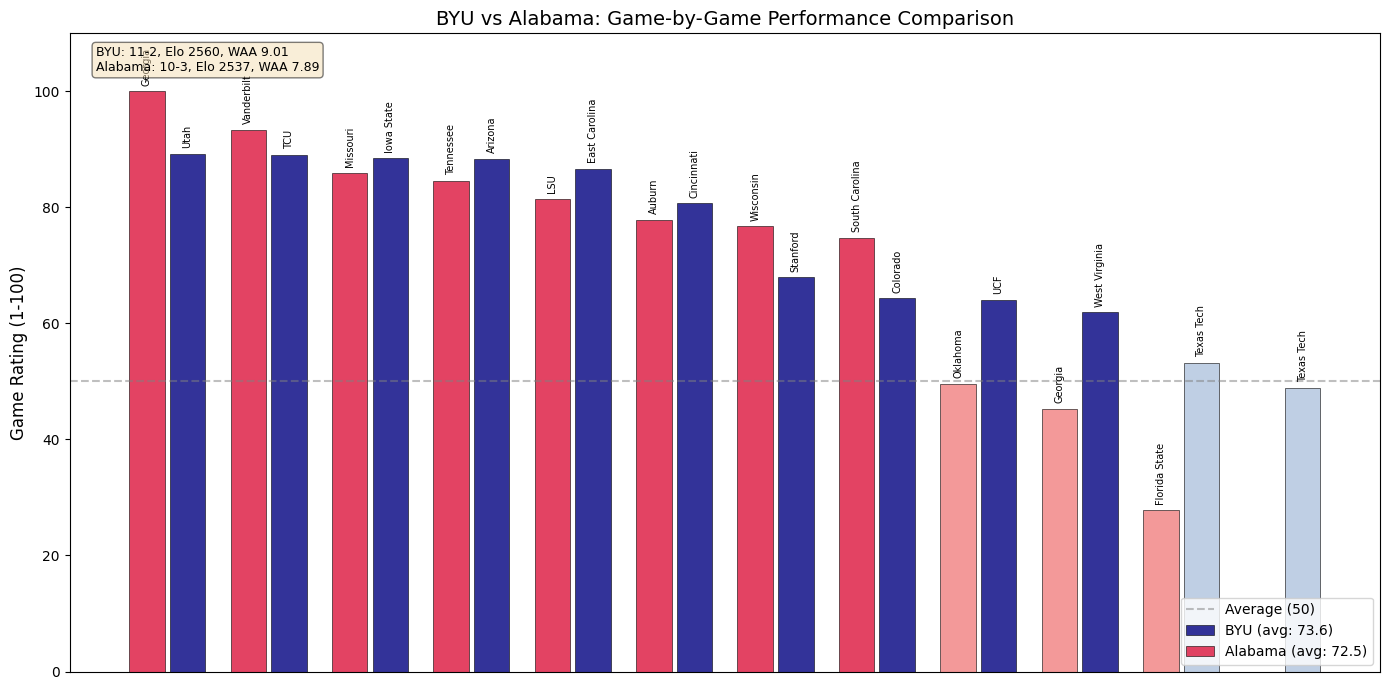


Visualization saved to C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data\BYU_Alabama_comparison.png


In [62]:
# =============================================================================
# DIAGNOSTIC
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define Path (User Local)
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'
games_out = f'{data_path}\\cfb_games_2025_enriched.csv'
teams_out = f'{data_path}\\cfb_elo_rankings_2025.csv'

# Load Data
df_games = pd.read_csv(games_out)
df_teams = pd.read_csv(teams_out)

# Ensure dates are datetime for sorting
if 'startDate' in df_games.columns:
    df_games['startDate'] = pd.to_datetime(df_games['startDate'])

print("\n" + "="*90)
print("DIAGNOSTIC")
print("="*90)

for team_to_check in ['BYU', 'Alabama']:
    print(f"\n{team_to_check}:")
    team_row = df_teams[df_teams['team'] == team_to_check].iloc[0]
    team_elo = team_row['elo']
    team_sos = team_row['sos']
    team_waa = team_row['waa']
    team_sos_rank = team_row['sos_rank']
    team_record = f"{team_row['wins']}-{team_row['losses']}"
   
    print(f" Record: {team_record}")
    print(f" Elo: {team_elo:.1f}")
    print(f" Prob vs Avg: {1 / (1 + 10 ** ((1500 - team_elo) / 400)):.1%}")
    print(f" SOS: {team_sos:.1f} (rank {team_sos_rank})")
    print(f" WAA: {team_waa:.2f}")
   
    print(f"\n Game-by-game:")
    print(f" {'Result':<6} {'Venue':<6} {'Opponent':<20} {'Score':<10} {'Opp Elo':>8} {'Dom':>6} {'Game Rating':>12}")
    print(f" {'-'*80}")
   
    # Filter and sort team's schedule
    team_schedule = df_games[
        (df_games['homeTeam'] == team_to_check) |
        (df_games['awayTeam'] == team_to_check)
    ].sort_values('startDate')
   
    included_games = []
    for _, row in team_schedule.iterrows():
        if row['homeTeam'] == team_to_check:
            excluded = row.get('home_excluded', False)
            if excluded:
                continue
            opp = row['awayTeam']
            venue = 'N' if row['neutralSite'] else 'H'
            score = f"{int(row['homePoints'])}-{int(row['awayPoints'])}"
            opp_elo = row['away_elo']
            dom = row['dominance']
            game_rating = row['game_rating_home_scaled']
            won = row['homePoints'] > row['awayPoints']
        else:
            excluded = row.get('away_excluded', False)
            if excluded:
                continue
            opp = row['homeTeam']
            venue = 'N' if row['neutralSite'] else 'A'
            score = f"{int(row['awayPoints'])}-{int(row['homePoints'])}"
            opp_elo = row['home_elo']
            dom = row['dominance']
            game_rating = row['game_rating_away_scaled']
            won = row['awayPoints'] > row['homePoints']
       
        included_games.append({
            'result': 'W' if won else 'L',
            'venue': venue,
            'opp': opp,
            'score': score,
            'opp_elo': opp_elo,
            'dom': dom,
            'game_rating': game_rating
        })
   
    for g in included_games:
        print(f" {g['result']:<6} {g['venue']:<6} {g['opp']:<20} {g['score']:<10} {g['opp_elo']:>8.1f} {g['dom']:>6.3f} {g['game_rating']:>12.1f}")
   
    print(f"\n Mean Game Rating: {team_row['avg_game_rating']:.1f}")

# =============================================================================
# VISUALIZATION: Game-by-game comparison
# =============================================================================
# ENTER TEAMS TO COMPARE
team_1 = 'BYU'
team_2 = 'Alabama'
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 7))
teams_to_compare = [team_1, team_2]
colors_win = {team_1: 'navy', team_2: 'crimson'}
colors_loss = {team_1: 'lightsteelblue', team_2: 'lightcoral'}
for idx, team_to_check in enumerate(teams_to_compare):
    team_row = df_teams[df_teams['team'] == team_to_check].iloc[0]
   
    # Filter and sort team's schedule
    team_schedule = df_games[
        (df_games['homeTeam'] == team_to_check) |
        (df_games['awayTeam'] == team_to_check)
    ].sort_values('startDate')
   
    game_data = []
    for _, row in team_schedule.iterrows():
        if row['homeTeam'] == team_to_check:
            excluded = row.get('home_excluded', False)
            if excluded:
                continue
            opp = row['awayTeam']
            game_rating = row['game_rating_home_scaled']
            won = row['homePoints'] > row['awayPoints']
        else:
            excluded = row.get('away_excluded', False)
            if excluded:
                continue
            opp = row['homeTeam']
            game_rating = row['game_rating_away_scaled']
            won = row['awayPoints'] > row['homePoints']
       
        game_data.append({
            'opponent': opp,
            'game_rating': game_rating,
            'win': won
        })
   
    # Sort by game rating
    game_data = sorted(game_data, key=lambda x: x['game_rating'], reverse=True)
   
    x_positions = np.arange(len(game_data))
    ratings = [g['game_rating'] for g in game_data]
    colors = [colors_win[team_to_check] if g['win'] else colors_loss[team_to_check] for g in game_data]
   
    offset = 0.2 if idx == 0 else -0.2
    bars = ax.bar(x_positions + offset, ratings, width=0.35, color=colors, alpha=0.8,
                  edgecolor='black', linewidth=0.5,
                  label=f"{team_to_check} (avg: {team_row['avg_game_rating']:.1f})")
   
    # Add opponent labels
    for i, g in enumerate(game_data):
        ax.text(i + offset, ratings[i] + 1, g['opponent'], rotation=90,
                ha='center', va='bottom', fontsize=7)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Average (50)')
ax.set_ylabel('Game Rating (1-100)', fontsize=12)
ax.set_title(f'{team_1} vs {team_2}: Game-by-Game Performance Comparison', fontsize=14)
ax.set_xticks([])
ax.set_ylim(0, 110)
ax.legend(loc='lower right')
# Add subtitle with key stats
record_1 = f"{df_teams[df_teams['team'] == team_1]['wins'].values[0]}-{df_teams[df_teams['team'] == team_1]['losses'].values[0]}"
record_2 = f"{df_teams[df_teams['team'] == team_2]['wins'].values[0]}-{df_teams[df_teams['team'] == team_2]['losses'].values[0]}"
elo_1 = df_teams[df_teams['team'] == team_1]['elo'].values[0]
elo_2 = df_teams[df_teams['team'] == team_2]['elo'].values[0]
waa_1 = df_teams[df_teams['team'] == team_1]['waa'].values[0]
waa_2 = df_teams[df_teams['team'] == team_2]['waa'].values[0]
ax.text(0.02, 0.98, f"{team_1}: {record_1}, Elo {elo_1:.0f}, WAA {waa_1:.2f}\n{team_2}: {record_2}, Elo {elo_2:.0f}, WAA {waa_2:.2f}",
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig(f'{data_path}\\{team_1}_{team_2}_comparison.png', dpi=150)
plt.show()
print(f"\nVisualization saved to {data_path}\\{team_1}_{team_2}_comparison.png")

In [53]:
# =============================================================================
# COMPARABLE GAMES FINDER
# =============================================================================
import pandas as pd
import numpy as np

# Define Path (User Local)
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'
games_out = f'{data_path}\\cfb_games_2025_enriched.csv'
teams_out = f'{data_path}\\cfb_elo_rankings_2025.csv'

# Load Data
df_games = pd.read_csv(games_out)
df_teams = pd.read_csv(teams_out)

# Ensure dates are datetime for sorting
if 'startDate' in df_games.columns:
    df_games['startDate'] = pd.to_datetime(df_games['startDate'])

# ENTER GAME TO ANALYZE
team_of_interest = 'Alabama'
opponent_of_interest = 'Georgia'
game_number = 1 # Which occurrence (1 = first meeting, 2 = second meeting, etc.)

# Find the game row
team_schedule = df_games[
    (df_games['homeTeam'].isin([team_of_interest, opponent_of_interest])) &
    (df_games['awayTeam'].isin([team_of_interest, opponent_of_interest]))
].sort_values('startDate')

if len(team_schedule) < game_number:
    print(f"Game not found: {team_of_interest} vs {opponent_of_interest} (game #{game_number})")
else:
    target_row = team_schedule.iloc[game_number - 1]
    if team_of_interest == target_row['homeTeam']:
        is_home = True
        target_rating = target_row['game_rating_home_scaled']
        excluded = target_row.get('home_excluded', False)
        venue = 'N' if target_row['neutralSite'] else 'H'
        pts_for = target_row['homePoints']
        pts_against = target_row['awayPoints']
        opp_elo = target_row['away_elo']
        dominance = target_row['dominance']
    else:
        is_home = False
        target_rating = target_row['game_rating_away_scaled']
        excluded = target_row.get('away_excluded', False)
        venue = 'N' if target_row['neutralSite'] else 'A'
        pts_for = target_row['awayPoints']
        pts_against = target_row['homePoints']
        opp_elo = target_row['home_elo']
        dominance = target_row['dominance']
    
    if excluded:
        print(f"Target game excluded from {team_of_interest}'s record.")
    else:
        won = pts_for > pts_against
        result = "W" if won else "L"
        target_score = f"{int(pts_for)}-{int(pts_against)}"
        print(f"Target Game: {team_of_interest} {result} {target_score} vs {opponent_of_interest} ({venue})")
        print(f"Game Rating: {target_rating:.1f}")
        print(f"Opponent Elo: {opp_elo:.1f}")
        print("\n" + "="*110)
        
        # Build list of all game performances (only included perspectives)
        all_performances = []
        
        for _, row in df_games.iterrows():
            if not row.get('home_excluded', False):
                home_won = row['homePoints'] > row['awayPoints']
                all_performances.append({
                    'team': row['homeTeam'],
                    'opponent': row['awayTeam'],
                    'pts_for': row['homePoints'],
                    'pts_against': row['awayPoints'],
                    'result': 'W' if home_won else 'L',
                    'venue': 'N' if row['neutralSite'] else 'H',
                    'dominance': row['dominance'],
                    'opp_elo': row['away_elo'],
                    'game_rating': row['game_rating_home_scaled']
                })
            if not row.get('away_excluded', False):
                away_won = row['awayPoints'] > row['homePoints']
                all_performances.append({
                    'team': row['awayTeam'],
                    'opponent': row['homeTeam'],
                    'pts_for': row['awayPoints'],
                    'pts_against': row['homePoints'],
                    'result': 'W' if away_won else 'L',
                    'venue': 'N' if row['neutralSite'] else 'A',
                    'dominance': row['dominance'],
                    'opp_elo': row['home_elo'],
                    'game_rating': row['game_rating_away_scaled']
                })
        
        # Sort by distance from target rating
        all_performances = sorted(all_performances, key=lambda x: abs(x['game_rating'] - target_rating))
        
        # Get 10 above and 10 below
        above = sorted([g for g in all_performances if g['game_rating'] >= target_rating],
                       key=lambda x: x['game_rating'])[:11]
        below = sorted([g for g in all_performances if g['game_rating'] < target_rating],
                       key=lambda x: x['game_rating'], reverse=True)[:10]
        
        comparable = sorted(above + below, key=lambda x: x['game_rating'], reverse=True)
        
        print(f"\n{'Team':<22} {'W/L':<5} {'H/A':<5} {'Score':<10} {'Opponent':<22} {'Opp Elo':>8} {'Dom':>6} {'Rating':>7}")
        print("-"*110)
        
        for g in comparable:
            score = f"{int(g['pts_for'])}-{int(g['pts_against'])}"
            is_target = g['team'] == team_of_interest and g['opponent'] == opponent_of_interest and abs(g['game_rating'] - target_rating) < 0.01
            marker = " <--" if is_target else ""
            print(f"{g['team']:<22} {g['result']:<5} {g['venue']:<5} {score:<10} {g['opponent']:<22} {g['opp_elo']:>8.1f} {g['dominance']:>6.3f} {g['game_rating']:>7.1f}{marker}")

Target Game: Alabama W 24-21 vs Georgia (A)
Game Rating: 100.0
Opponent Elo: 2627.3


Team                   W/L   H/A   Score      Opponent                Opp Elo    Dom  Rating
--------------------------------------------------------------------------------------------------------------
Texas Tech             W     A     34-10      Utah                     2524.1  0.965   100.0
Indiana                W     H     63-10      Illinois                 2307.9  0.998   100.0
Alabama                W     A     24-21      Georgia                  2627.3  0.892   100.0 <--
Indiana                W     A     30-20      Oregon                   2752.3  0.917   100.0
Texas                  W     N     23-6       Oklahoma                 2568.5  0.945   100.0
Texas Tech             W     N     34-7       BYU                      2560.5  0.970   100.0
Georgia                W     N     28-7       Alabama                  2536.6  0.971   100.0
Indiana                W     N     13-10      Ohio Stat

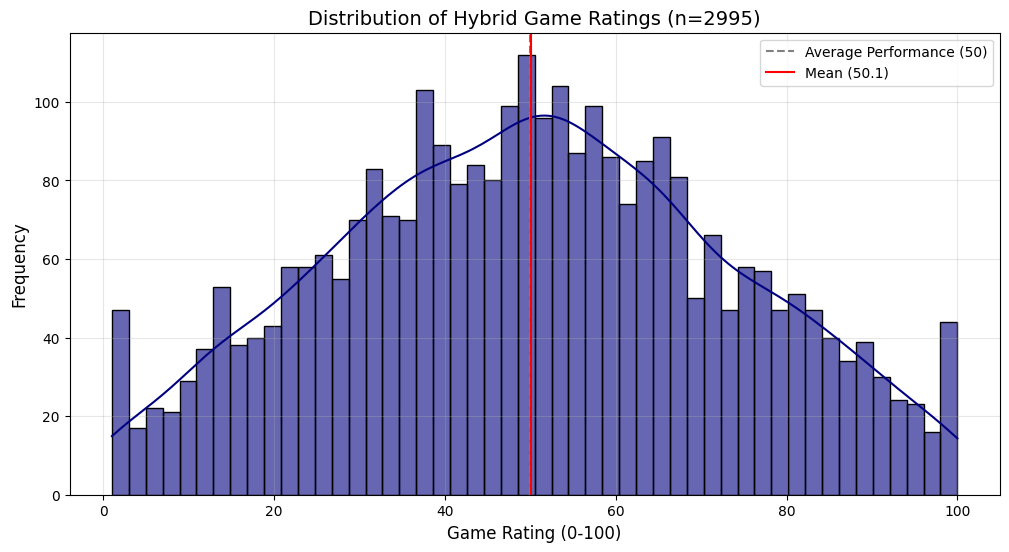

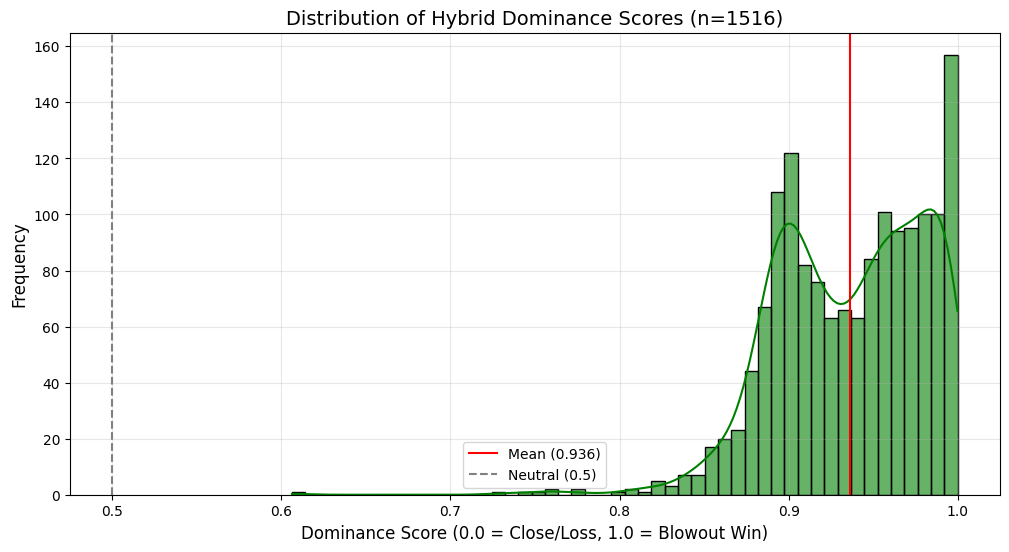

Dominance Mean: 0.936
Dominance Median: 0.942


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# =============================================================================
# LOAD DATA
# =============================================================================
# Define Path (User Local)
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'
games_out = f'{data_path}\\cfb_games_2025_enriched.csv'

# Load Game Data
df_games = pd.read_csv(games_out)

# =============================================================================
# 1. COLLECT ALL INCLUDED GAME RATINGS (RAW AND DETAILS)
# =============================================================================
all_ratings = []  # Raw implied ratings for included performances
game_details = []
print("Collecting ratings for all included performances...")
for _, row in df_games.iterrows():
    if not row.get('home_excluded', False):
        # Add home's perspective
        all_ratings.append(row['game_rating_home'])
        game_details.append({
            'team': row['homeTeam'],
            'opponent': row['awayTeam'],
            'score': f"{int(row['homePoints'])}-{int(row['awayPoints'])}",
            'raw_rating': row['game_rating_home']
        })
    if not row.get('away_excluded', False):
        # Add away's perspective
        all_ratings.append(row['game_rating_away'])
        game_details.append({
            'team': row['awayTeam'],
            'opponent': row['homeTeam'],
            'score': f"{int(row['awayPoints'])}-{int(row['homePoints'])}",
            'raw_rating': row['game_rating_away']
        })

# =============================================================================
# 2. DEFINE SCALING (Robust to Outliers)
# =============================================================================
# We pin 0 and 100 to the 1st and 99th percentiles to handle outliers like 70-0
rating_floor = np.percentile(all_ratings, 1)
rating_ceiling = np.percentile(all_ratings, 99)
def scale_rating(r):
    clipped = np.clip(r, rating_floor, rating_ceiling)
    return 1 + 99 * (clipped - rating_floor) / (rating_ceiling - rating_floor)
# Apply scaling
scaled_ratings = [scale_rating(r) for r in all_ratings]

# =============================================================================
# 3. PLOT DISTRIBUTION
# =============================================================================
plt.figure(figsize=(12, 6))
sns.histplot(scaled_ratings, bins=50, kde=True, color='navy', alpha=0.6)
# Add Lines for Context
plt.axvline(50, color='gray', linestyle='--', label='Average Performance (50)')
plt.axvline(np.mean(scaled_ratings), color='red', linestyle='-', label=f'Mean ({np.mean(scaled_ratings):.1f})')
plt.title(f"Distribution of Hybrid Game Ratings (n={len(scaled_ratings)})", fontsize=14)
plt.xlabel("Game Rating (0-100)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# =============================================================================
# 4. PLOT DOMINANCE DISTRIBUTION
# =============================================================================

# Drop any potential NaNs for clean plotting
dom_values = df_games['dominance'].dropna()

plt.figure(figsize=(12, 6))
sns.histplot(dom_values, bins=50, kde=True, color='green', alpha=0.6)

# Add Lines for Context
mean_dom = dom_values.mean()
plt.axvline(mean_dom, color='red', linestyle='-', label=f'Mean ({mean_dom:.3f})')
plt.axvline(0.5, color='gray', linestyle='--', label='Neutral (0.5)')

plt.title(f"Distribution of Hybrid Dominance Scores (n={len(dom_values)})", fontsize=14)
plt.xlabel("Dominance Score (0.0 = Close/Loss, 1.0 = Blowout Win)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print Stats
print(f"Dominance Mean: {mean_dom:.3f}")
print(f"Dominance Median: {dom_values.median():.3f}")

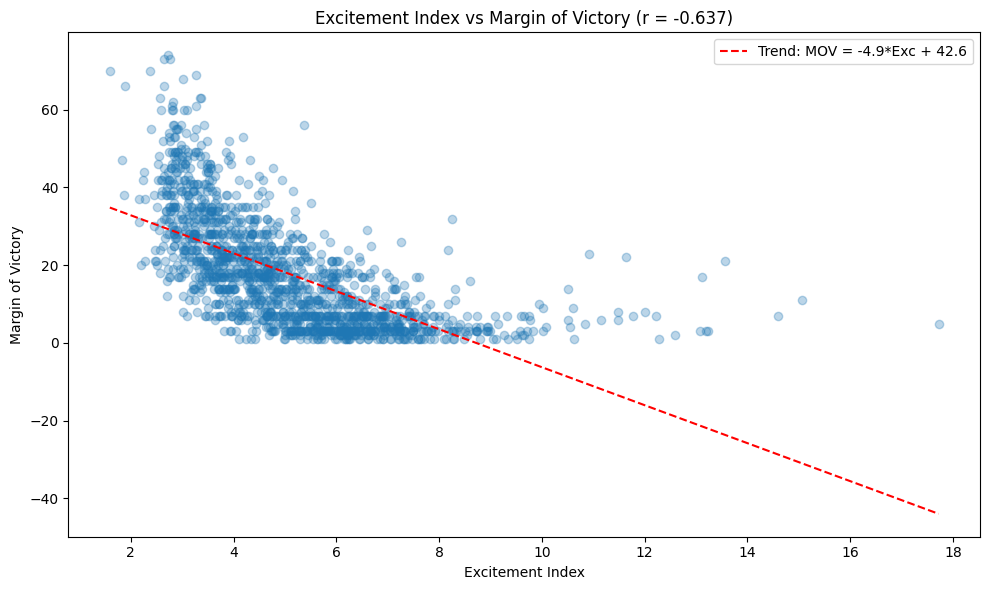


Correlation: -0.637
Saved to C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data\excitement_vs_mov.png


In [63]:
# =============================================================================
# EXCITEMENT INDEX vs MARGIN OF VICTORY
# =============================================================================

import matplotlib.pyplot as plt

# Calculate margin of victory for each game
mov_data = []

for _, game in df.iterrows():
    home_pts = game['homePoints']
    away_pts = game['awayPoints']
    excitement = game['excitementIndex']
    
    mov = abs(home_pts - away_pts)
    mov_data.append({
        'mov': mov,
        'excitement': excitement
    })

movs = [g['mov'] for g in mov_data]
excitements = [g['excitement'] for g in mov_data]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(excitements, movs, alpha=0.3)

# Add trend line
z = np.polyfit(excitements, movs, 1)
p = np.poly1d(z)
x_line = np.linspace(min(excitements), max(excitements), 100)
ax.plot(x_line, p(x_line), "r--", label=f'Trend: MOV = {z[0]:.1f}*Exc + {z[1]:.1f}')

# Correlation
corr = np.corrcoef(excitements, movs)[0, 1]

ax.set_xlabel('Excitement Index')
ax.set_ylabel('Margin of Victory')
ax.set_title(f'Excitement Index vs Margin of Victory (r = {corr:.3f})')
ax.legend()

plt.tight_layout()
plt.savefig(f'{data_path}\\excitement_vs_mov.png', dpi=150)
plt.show()

print(f"\nCorrelation: {corr:.3f}")
print(f"Saved to {data_path}\\excitement_vs_mov.png")

In [169]:
# =============================================================================
# OPTIMIZE PARAMETERS FOR ITERATIVE ELO MODEL (FAST VERSION)
# =============================================================================

import pandas as pd
import numpy as np
from scipy.optimize import minimize

print("="*70)
print("OPTIMIZING ITERATIVE ELO MODEL PARAMETERS (FAST)")
print("="*70)

# 1. LOAD DATA
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'
df = pd.read_csv(f'{data_path}\\cfb_games_2025.csv')

df = df[
    (df['completed'] == True) & 
    (df['homeClassification'].isin(['fbs', 'fcs'])) & 
    (df['awayClassification'].isin(['fbs', 'fcs'])) &
    (df['excitementIndex'].notna())
].copy().reset_index(drop=True)

print(f"Games loaded: {len(df)}")

teams = sorted(set(df['homeTeam'].unique()) | set(df['awayTeam'].unique()))
team_to_idx = {t: i for i, t in enumerate(teams)}
n_teams = len(teams)
print(f"Teams: {n_teams}")

# Pre-extract as numpy arrays
home_idx = np.array([team_to_idx[t] for t in df['homeTeam']])
away_idx = np.array([team_to_idx[t] for t in df['awayTeam']])
home_win = (df['homePoints'] > df['awayPoints']).values.astype(float)
neutral = df['neutralSite'].values.astype(float)
excitement = df['excitementIndex'].fillna(6.0).values
mov = np.abs(df['homePoints'] - df['awayPoints']).values

n_games = len(df)
print("Data prepared.\n")

# 2. FAST OBJECTIVE FUNCTION
def evaluate_model_fast(params):
    k_exc, x0_exc = params[0], params[1]
    k_mov, x0_mov = params[2], params[3]
    k_mix, x0_mix = params[4], params[5]
    HFA = params[6]
    divisor = params[7]
    
    # Vectorized dominance calculation
    dom_exc = 1 / (1 + np.exp(k_exc * (excitement - x0_exc)))
    dom_mov = 1 / (1 + np.exp(-k_mov * (mov - x0_mov)))
    weight_exc = 1 / (1 + np.exp(k_mix * (mov - x0_mix)))
    dominance = (weight_exc * dom_exc) + ((1 - weight_exc) * dom_mov)
    
    # Actual scores (vectorized)
    home_actual = np.where(home_win, 0.5 + 0.5 * dominance, 0.5 - 0.5 * dominance)
    away_actual = 1 - home_actual
    
    # Clip actuals
    home_actual = np.clip(home_actual, 0.001, 0.999)
    away_actual = np.clip(away_actual, 0.001, 0.999)
    
    # HFA adjustments for implied rating (away wins more impressive)
    hfa_home = -HFA * (1 - neutral)  # Home gets penalty
    hfa_away = HFA * (1 - neutral)   # Away gets bonus
    
    # Iterative Elo (vectorized as much as possible)
    elo = np.full(n_teams, 1500.0)
    
    for iteration in range(50):  # Reduced iterations
        # Calculate implied ratings for each game
        home_implied = elo[away_idx] + hfa_home - divisor * np.log10((1 - home_actual) / home_actual)
        away_implied = elo[home_idx] + hfa_away - divisor * np.log10((1 - away_actual) / away_actual)
        
        # Average implied ratings per team
        new_elo = np.zeros(n_teams)
        counts = np.zeros(n_teams)
        
        np.add.at(new_elo, home_idx, home_implied)
        np.add.at(new_elo, away_idx, away_implied)
        np.add.at(counts, home_idx, 1)
        np.add.at(counts, away_idx, 1)
        
        counts[counts == 0] = 1  # Avoid division by zero
        new_elo = new_elo / counts
        
        # Center at 1500
        new_elo = new_elo - np.mean(new_elo) + 1500
        
        # Check convergence
        max_change = np.max(np.abs(new_elo - elo))
        elo = new_elo
        
        if max_change < 1.0:  # Looser convergence for speed
            break
    
    # Calculate predictions (vectorized)
    hfa_pred = HFA * (1 - neutral)  # Home team gets advantage for prediction
    pred = 1 / (1 + 10 ** ((elo[away_idx] - elo[home_idx] - hfa_pred) / divisor))
    pred = np.clip(pred, 0.001, 0.999)
    
    # Log loss
    log_loss_val = -np.mean(home_win * np.log(pred) + (1 - home_win) * np.log(1 - pred))
    
    # Calibration error (simplified)
    cal_error = 0
    for bucket in [0.1, 0.3, 0.5, 0.7, 0.9]:
        mask = (pred >= bucket - 0.15) & (pred < bucket + 0.15)
        if mask.sum() > 5:
            cal_error += np.abs(pred[mask].mean() - home_win[mask].mean()) * mask.sum()
    cal_error /= n_games
    
    # Regularization
    reg = 0.001 * (k_exc**2 + k_mov**2 + k_mix**2)
    
    return log_loss_val + 0.3 * cal_error + reg

# 3. TEST INITIAL SPEED
print("Testing evaluation speed...")
import time
start = time.time()
test_score = evaluate_model_fast([0.34, 20.0, 0.31, 2.6, 0.01, 24.8, 82.0, 400.0])
elapsed = time.time() - start
print(f"Single evaluation: {elapsed:.3f} seconds, score: {test_score:.5f}")
print(f"Estimated optimization time: {elapsed * 100:.0f} seconds\n")

# 4. RUN OPTIMIZATION
print("Optimizing...")

initial_guess = [0.34, 20.0, 0.31, 2.6, 0.01, 24.8, 82.0, 400.0]

bounds = [
    (0.01, 2.0),   # k_exc
    (0, 20),       # x0_exc
    (0.01, 2.0),   # k_mov
    (0, 30),       # x0_mov
    (0.001, 1.0),  # k_mix
    (0, 60),       # x0_mix
    (30, 150),     # HFA
    (200, 800)     # elo_divisor
]

result = minimize(
    evaluate_model_fast,
    initial_guess,
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 50, 'disp': True}
)

# 5. RESULTS
p = result.x
print("\n" + "="*70)
print("OPTIMIZED PARAMETERS")
print("="*70)
print(f"\nDominance Formula:")
print(f"  Excitement:  k={p[0]:.4f}, x0={p[1]:.2f}")
print(f"  MOV:         k={p[2]:.4f}, x0={p[3]:.2f}")
print(f"  Mix:         k={p[4]:.4f}, x0={p[5]:.2f}")
print(f"\nElo Parameters:")
print(f"  HFA:         {p[6]:.1f}")
print(f"  Divisor:     {p[7]:.1f}")
print(f"\nFinal Score: {result.fun:.5f}")

# 6. QUICK VALIDATION
print("\n" + "="*70)
print("QUICK VALIDATION")
print("="*70)

# Recalculate with optimal params
k_exc, x0_exc = p[0], p[1]
k_mov, x0_mov = p[2], p[3]
k_mix, x0_mix = p[4], p[5]
HFA_opt = p[6]
divisor_opt = p[7]

dom_exc = 1 / (1 + np.exp(k_exc * (excitement - x0_exc)))
dom_mov = 1 / (1 + np.exp(-k_mov * (mov - x0_mov)))
weight_exc = 1 / (1 + np.exp(k_mix * (mov - x0_mix)))
dominance = (weight_exc * dom_exc) + ((1 - weight_exc) * dom_mov)

home_actual = np.where(home_win, 0.5 + 0.5 * dominance, 0.5 - 0.5 * dominance)
away_actual = 1 - home_actual
home_actual = np.clip(home_actual, 0.001, 0.999)
away_actual = np.clip(away_actual, 0.001, 0.999)

hfa_home = -HFA_opt * (1 - neutral)
hfa_away = HFA_opt * (1 - neutral)

elo = np.full(n_teams, 1500.0)
for iteration in range(100):
    home_implied = elo[away_idx] + hfa_home - divisor_opt * np.log10((1 - home_actual) / home_actual)
    away_implied = elo[home_idx] + hfa_away - divisor_opt * np.log10((1 - away_actual) / away_actual)
    
    new_elo = np.zeros(n_teams)
    counts = np.zeros(n_teams)
    np.add.at(new_elo, home_idx, home_implied)
    np.add.at(new_elo, away_idx, away_implied)
    np.add.at(counts, home_idx, 1)
    np.add.at(counts, away_idx, 1)
    counts[counts == 0] = 1
    new_elo = new_elo / counts
    new_elo = new_elo - np.mean(new_elo) + 1500
    
    if np.max(np.abs(new_elo - elo)) < 0.1:
        print(f"Converged at iteration {iteration}")
        break
    elo = new_elo

print(f"\nElo Std Dev: {np.std(elo):.1f}")
print(f"Elo Range: {elo.min():.1f} to {elo.max():.1f}")

# Predictions
hfa_pred = HFA_opt * (1 - neutral)
pred = 1 / (1 + 10 ** ((elo[away_idx] - elo[home_idx] - hfa_pred) / divisor_opt))
pred = np.clip(pred, 0.001, 0.999)

accuracy = np.mean((pred > 0.5) == home_win)
print(f"Accuracy: {accuracy:.1%}")

# Calibration
print(f"\nCalibration:")
print(f"  {'Bucket':<8} {'Count':<8} {'Pred':<8} {'Actual':<8} {'Diff':<8}")
for bucket in np.arange(0.1, 1.0, 0.1):
    mask = (pred >= bucket - 0.05) & (pred < bucket + 0.05)
    if mask.sum() > 0:
        print(f"  {bucket:<8.1f} {mask.sum():<8} {pred[mask].mean():<8.3f} {home_win[mask].mean():<8.3f} {home_win[mask].mean() - pred[mask].mean():>+.3f}")

# Top 10
print(f"\nTop 10:")
sorted_idx = np.argsort(-elo)
for i in range(10):
    idx = sorted_idx[i]
    print(f"  {i+1:2}. {teams[idx]:<25} {elo[idx]:.1f}")

# Output for Cell 3
print("\n" + "="*70)
print("COPY TO CELL 3:")
print("="*70)
print(f"""
K_EXC, X0_EXC = {p[0]:.4f}, {p[1]:.2f}
K_MOV, X0_MOV = {p[2]:.4f}, {p[3]:.2f}
K_MIX, X0_MIX = {p[4]:.4f}, {p[5]:.2f}
HFA = {p[6]:.1f}
ELO_DIVISOR = {p[7]:.1f}
""")

OPTIMIZING ITERATIVE ELO MODEL PARAMETERS (FAST)
Games loaded: 1516
Teams: 265
Data prepared.

Testing evaluation speed...
Single evaluation: 0.006 seconds, score: 0.37866
Estimated optimization time: 1 seconds

Optimizing...

OPTIMIZED PARAMETERS

Dominance Formula:
  Excitement:  k=0.1844, x0=20.00
  MOV:         k=0.2219, x0=2.60
  Mix:         k=0.1096, x0=24.80

Elo Parameters:
  HFA:         82.0
  Divisor:     400.0

Final Score: 0.33941

QUICK VALIDATION
Converged at iteration 56

Elo Std Dev: 550.2
Elo Range: 284.3 to 2844.2
Accuracy: 84.9%

Calibration:
  Bucket   Count    Pred     Actual   Diff    
  0.1      157      0.097    0.121    +0.024
  0.2      94       0.198    0.191    -0.007
  0.3      87       0.301    0.368    +0.067
  0.4      58       0.408    0.431    +0.023
  0.5      66       0.496    0.455    -0.041
  0.6      82       0.602    0.524    -0.077
  0.7      104      0.701    0.769    +0.068
  0.8      106      0.801    0.802    +0.001
  0.9      214      0.9

In [190]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss

# =============================================================================
# 1. SETUP DATA (From Loaded DataFrame)
# =============================================================================
# Ensure 'df' is loaded from your previous cells.
if 'startDate' in df.columns:
    df['startDate'] = pd.to_datetime(df['startDate'])
    df = df.sort_values('startDate').reset_index(drop=True)

# Use your EXISTING optimized dominance logic
def get_current_dominance(row):
    exc = row['excitementIndex'] if pd.notna(row['excitementIndex']) else 6.0
    dom_exc = 1 / (1 + np.exp(0.340 * (exc - 20.0)))
    mov = abs(row['homePoints'] - row['awayPoints'])
    dom_mov = 1 / (1 + np.exp(-0.306 * (mov - 2.6)))
    weight_exc = 1 / (1 + np.exp(0.010 * (mov - 24.8)))
    return (weight_exc * dom_exc) + ((1 - weight_exc) * dom_mov)

# Pre-calculate dominance
df['dominance'] = df.apply(get_current_dominance, axis=1)

# Pre-build game lists
precalc_games = {team: [] for team in teams}
for _, row in df.iterrows():
    h, a, n = row['homeTeam'], row['awayTeam'], row['neutralSite']
    h_win = row['homePoints'] > row['awayPoints']
    mov = abs(row['homePoints'] - row['awayPoints'])
    dom = row['dominance']
    
    h_act = 0.5 + 0.5 * dom if h_win else 0.5 - 0.5 * dom
    a_act = 0.5 - 0.5 * dom if h_win else 0.5 + 0.5 * dom
    
    precalc_games[h].append({'opp': a, 'act': h_act, 'is_home': True, 'neut': n, 'won': h_win, 'mov': mov})
    precalc_games[a].append({'opp': h, 'act': a_act, 'is_home': False, 'neut': n, 'won': not h_win, 'mov': mov})

# =============================================================================
# 2. DEFINE THE TIERED EXCLUSION TEST
# =============================================================================

def test_tiered_exclusion(elo_cutoff, cap_weak, cap_strong):
    # elo_cutoff: Opponent Elo above this is "Strong", below is "Weak"
    # cap_weak: Max MOV credited against weak teams
    # cap_strong: Max MOV credited against strong teams (999 = No Cap)
    
    elos = {t: 1500.0 for t in teams}
    HFA = 80.6
    
    for _ in range(40): # Convergence loop
        new_elos = {}
        for team in teams:
            if not precalc_games[team]:
                new_elos[team] = 1500.0
                continue
            
            implied_ratings = []
            
            for g in precalc_games[team]:
                opp_rating = elos[g['opp']]
                
                # --- TIERED LOGIC ---
                if g['won']:
                    # Determine the cap based on opponent strength
                    current_cap = cap_strong if opp_rating >= elo_cutoff else cap_weak
                    
                    # Apply Mercy Rule
                    if g['mov'] > current_cap:
                        continue # Exclude this game
                
                # Standard Elo Calc
                if g['neut']: adj = 0
                elif g['is_home']: adj = -HFA
                else: adj = HFA
                
                act = np.clip(g['act'], 0.001, 0.999)
                implied = opp_rating + adj - 400 * np.log10((1 - act) / act)
                implied_ratings.append(implied)
            
            if not implied_ratings:
                new_elos[team] = elos[team]
            else:
                new_elos[team] = np.mean(implied_ratings)
        
        # Normalize
        avg_val = np.mean(list(new_elos.values()))
        elos = {t: r - avg_val + 1500 for t, r in new_elos.items()}
    
    # Score Model
    preds, actuals = [], []
    for _, row in df.iterrows():
        h, a, n = row['homeTeam'], row['awayTeam'], row['neutralSite']
        h_win = 1 if row['homePoints'] > row['awayPoints'] else 0
        hfa_val = 0 if n else HFA
        prob = 1 / (1 + 10 ** ((elos[a] - elos[h] - hfa_val) / 400))
        preds.append(prob)
        actuals.append(h_win)
        
    return log_loss(actuals, preds)

# =============================================================================
# 3. RUN THE TIERED GRID SEARCH
# =============================================================================

print("Running Tiered Exclusion Optimization...")
print(f"{'Elo Cut':<8} {'Weak Cap':<10} {'Strong Cap':<10} {'Log Loss':<10}")
print("-" * 45)

results_log = []

# Search Space
# Elo Cutoff: Defines "Quality Opponent" (1500=Avg, 2000=Elite)
elo_cutoffs = [500, 750, 1000, 1250] 
# Weak Cap: Strict limits for beating bad teams
weak_caps = [24, 28, 32] 
# Strong Cap: Loose limits for beating good teams (999 = Unlimited)
strong_caps = [40, 50, 60, 999]

for ec in elo_cutoffs:
    for wc in weak_caps:
        for sc in strong_caps:
            # Optimization: Skip if Strong Cap <= Weak Cap (redundant)
            if sc != 999 and sc <= wc: continue
                
            score = test_tiered_exclusion(ec, wc, sc)
            # Print only better results to reduce clutter
            if not results_log or score < min(r[3] for r in results_log):
                print(f"{ec:<8} {wc:<10} {sc:<10} {score:.5f} *")
            results_log.append((ec, wc, sc, score))

# Best Result
best = min(results_log, key=lambda x: x[3])
print("-" * 45)
print(f"OPTIMAL SETTINGS:")
print(f"Opponent Elo Threshold: {best[0]}")
print(f"Cap vs Weak Opponents:  {best[1]} points")
print(f"Cap vs Strong Opponents: {best[2]} points")
print(f"Best Log Loss: {best[3]:.5f}")

Running Tiered Exclusion Optimization...
Elo Cut  Weak Cap   Strong Cap Log Loss  
---------------------------------------------
500      24         40         0.36473 *
500      24         50         0.36323 *
500      28         40         0.36311 *
500      28         50         0.36292 *
500      32         50         0.36273 *
---------------------------------------------
OPTIMAL SETTINGS:
Opponent Elo Threshold: 500
Cap vs Weak Opponents:  32 points
Cap vs Strong Opponents: 50 points
Best Log Loss: 0.36273


Filtered to 758 competitive games (top 50% by smallest ELO diff).
Estimated HFA: 69.5
MODEL VALIDATION

1. ELO DISTRIBUTION
 Teams: 265
 Mean Elo: 1500.0
 Std Dev: 574.9
 Min: 254.9 (St. Francis (PA))
 Max: 2929.7 (Indiana)
 Range: 2674.8

 Percentiles:
   1th: 299.8
   5th: 553.6
  25th: 1068.2
  50th: 1515.3
  75th: 1921.0
  95th: 2510.2
  99th: 2725.1

2. PREDICTION ACCURACY
 Games: 758
 Correct predictions: 553
 Accuracy: 73.0%

3. CALIBRATION (Do probabilities match reality?)

 Bucket     Count    Pred Avg   Actual Win%  Diff    
 --------------------------------------------------
 0.1        8        0.140      0.250        +0.110
 0.2        95       0.194      0.221        +0.027
 0.3        89       0.299      0.360        +0.061
 0.4        58       0.409      0.414        +0.005
 0.5        64       0.496      0.484        -0.012
 0.6        93       0.602      0.581        -0.022
 0.7        87       0.699      0.770        +0.071
 0.8        114      0.798      0.807      

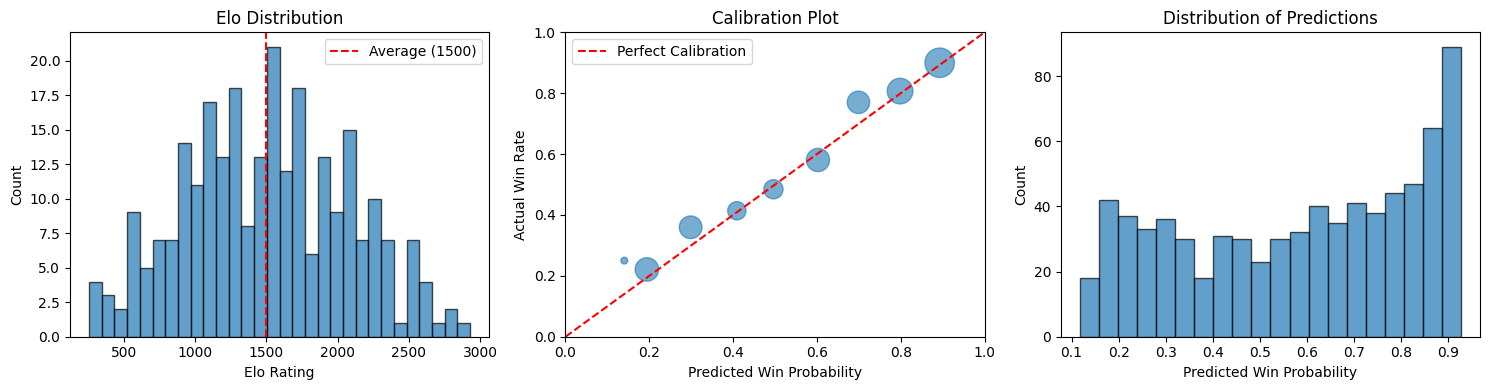


Visualization saved to C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data\model_validation.png


In [66]:
# =============================================================================
# MODEL VALIDATION
# =============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define Path (User Local)
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'
games_out = f'{data_path}\\cfb_games_2025_enriched.csv'
teams_out = f'{data_path}\\cfb_elo_rankings_2025.csv'

# Load Data
df_games = pd.read_csv(games_out)
df_teams = pd.read_csv(teams_out)

# Filter to top 50% competitive games (smallest ELO differences)
df_games['elo_diff'] = abs(df_games['home_elo'] - df_games['away_elo'])
df_games = df_games.sort_values('elo_diff').head(int(len(df_games) * 0.5)).copy()
print(f"Filtered to {len(df_games)} competitive games (top 50% by smallest ELO diff).")

# Recalculate HFA from df_games (matches original pre-flight calculation)
home_acts = []
for _, row in df_games.iterrows():
    if not row['neutralSite']:
        home_win = row['homePoints'] > row['awayPoints']
        dom = row['dominance']
        home_act = 0.5 + 0.5 * dom if home_win else 0.5 - 0.5 * dom
        home_acts.append(home_act)
avg_home = np.mean(home_acts)
HFA = -400 * np.log10((1 - avg_home) / avg_home)
print(f"Estimated HFA: {HFA:.1f}")

print("="*80)
print("MODEL VALIDATION")
print("="*80)
# -----------------------------------------------------------------------------
# 1. ELO DISTRIBUTION ANALYSIS
# -----------------------------------------------------------------------------
elo_values = df_teams['elo'].tolist()
teams = df_teams['team'].tolist()
# Note: fbs_teams definition skipped as unused in original code
print(f"\n1. ELO DISTRIBUTION")
print(f" Teams: {len(teams)}")
print(f" Mean Elo: {np.mean(elo_values):.1f}")
print(f" Std Dev: {np.std(elo_values):.1f}")
min_team = df_teams.loc[df_teams['elo'].idxmin(), 'team']
max_team = df_teams.loc[df_teams['elo'].idxmax(), 'team']
print(f" Min: {min(elo_values):.1f} ({min_team})")
print(f" Max: {max(elo_values):.1f} ({max_team})")
print(f" Range: {max(elo_values) - min(elo_values):.1f}")
# Percentiles
print(f"\n Percentiles:")
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f" {p:3}th: {np.percentile(elo_values, p):.1f}")
# -----------------------------------------------------------------------------
# 2. GAME-BY-GAME PREDICTION ACCURACY
# -----------------------------------------------------------------------------
print(f"\n2. PREDICTION ACCURACY")
correct = 0
total = 0
predictions = [] # (predicted_prob, actual_outcome)
for _, row in df_games.iterrows():
    home_elo = row['home_elo']
    away_elo = row['away_elo']
    hfa_adj = 0 if row['neutralSite'] else HFA
    pred_prob = 1 / (1 + 10 ** ((away_elo - home_elo - hfa_adj) / 400))
    actual = 1 if row['homePoints'] > row['awayPoints'] else 0
    predictions.append((pred_prob, actual))
    # Did we predict correctly? (>50% and won, or <50% and lost)
    if (pred_prob > 0.5 and actual == 1) or (pred_prob < 0.5 and actual == 0):
        correct += 1
    elif pred_prob == 0.5:
        correct += 0.5 # Tie
    total += 1
print(f" Games: {total}")
print(f" Correct predictions: {correct}")
print(f" Accuracy: {correct/total:.1%}")
# -----------------------------------------------------------------------------
# 3. CALIBRATION ANALYSIS
# -----------------------------------------------------------------------------
print(f"\n3. CALIBRATION (Do probabilities match reality?)")
# Bucket predictions
buckets = {}
for pred, actual in predictions:
    bucket = round(pred * 10) / 10 # Round to nearest 0.1
    if bucket not in buckets:
        buckets[bucket] = {'pred_sum': 0, 'actual_sum': 0, 'count': 0}
    buckets[bucket]['pred_sum'] += pred
    buckets[bucket]['actual_sum'] += actual
    buckets[bucket]['count'] += 1
print(f"\n {'Bucket':<10} {'Count':<8} {'Pred Avg':<10} {'Actual Win%':<12} {'Diff':<8}")
print(f" {'-'*50}")
calibration_errors = []
for bucket in sorted(buckets.keys()):
    b = buckets[bucket]
    pred_avg = b['pred_sum'] / b['count']
    actual_avg = b['actual_sum'] / b['count']
    diff = actual_avg - pred_avg
    calibration_errors.append(abs(diff) * b['count'])
    print(f" {bucket:<10.1f} {b['count']:<8} {pred_avg:<10.3f} {actual_avg:<12.3f} {diff:>+.3f}")
mean_cal_error = sum(calibration_errors) / total
print(f"\n Mean Calibration Error: {mean_cal_error:.3f}")
# -----------------------------------------------------------------------------
# 4. UPSET ANALYSIS
# -----------------------------------------------------------------------------
print(f"\n4. UPSET ANALYSIS")
upsets = [(p, a) for p, a in predictions if (p > 0.7 and a == 0) or (p < 0.3 and a == 1)]
print(f" Major upsets (>70% favorite lost): {len(upsets)}")
print(f" Upset rate: {len(upsets)/total:.1%}")
heavy_favorites = [(p, a) for p, a in predictions if p > 0.9]
heavy_fav_losses = sum(1 for p, a in heavy_favorites if a == 0)
print(f" 90%+ favorites: {len(heavy_favorites)}, losses: {heavy_fav_losses} ({heavy_fav_losses/len(heavy_favorites) if heavy_favorites else 0:.1%})")
# -----------------------------------------------------------------------------
# 5. VISUALIZATION
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Elo Distribution
axes[0].hist(elo_values, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=1500, color='red', linestyle='--', label='Average (1500)')
axes[0].set_xlabel('Elo Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Elo Distribution')
axes[0].legend()
# Calibration Plot
bucket_centers = sorted(buckets.keys())
pred_avgs = [buckets[b]['pred_sum']/buckets[b]['count'] for b in bucket_centers]
actual_avgs = [buckets[b]['actual_sum']/buckets[b]['count'] for b in bucket_centers]
counts = [buckets[b]['count'] for b in bucket_centers]
axes[1].scatter(pred_avgs, actual_avgs, s=[c*3 for c in counts], alpha=0.6)
axes[1].plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
axes[1].set_xlabel('Predicted Win Probability')
axes[1].set_ylabel('Actual Win Rate')
axes[1].set_title('Calibration Plot')
axes[1].legend()
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
# Prediction distribution
pred_probs = [p for p, a in predictions]
axes[2].hist(pred_probs, bins=20, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Predicted Win Probability')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Predictions')
plt.tight_layout()
plt.savefig(f'{data_path}\\model_validation.png', dpi=150)
plt.show()
print(f"\nVisualization saved to {data_path}\\model_validation.png")

In [67]:
import pandas as pd
import numpy as np

data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'
games_out = f'{data_path}\\cfb_games_2025_enriched.csv'
df_games = pd.read_csv(games_out)

# Filter to top 50% competitive games (smallest ELO differences)
df_games['elo_diff'] = abs(df_games['home_elo'] - df_games['away_elo'])
df_games = df_games.sort_values('elo_diff').head(int(len(df_games) * 0.5)).copy()
print(f"Filtered to {len(df_games)} competitive games (top 50% by smallest ELO diff).")

# Recalculate HFA as in your validation code
home_acts = []
for _, row in df_games.iterrows():
    if not row['neutralSite']:
        home_win = row['homePoints'] > row['awayPoints']
        dom = row['dominance']
        home_act = 0.5 + 0.5 * dom if home_win else 0.5 - 0.5 * dom
        home_acts.append(home_act)
avg_home = np.mean(home_acts)
HFA = -400 * np.log10((1 - avg_home) / avg_home)
print(f"Estimated HFA: {HFA:.1f}")

probs = []
actuals = []
for _, row in df_games.iterrows():
    hfa_adj = 0 if row['neutralSite'] else HFA
    prob = 1 / (1 + 10 ** ((row['away_elo'] - row['home_elo'] - hfa_adj) / 400))
    probs.append(prob)
    actuals.append(1 if row['homePoints'] > row['awayPoints'] else 0)

probs = np.array(probs)
actuals = np.array(actuals)

# Clip to avoid log(0)
probs = np.clip(probs, 1e-10, 1 - 1e-10)

# Log loss
log_loss_val = -np.mean(actuals * np.log(probs) + (1 - actuals) * np.log(1 - probs))
print(f"Log Loss: {log_loss_val:.4f}")

# Brier score
brier_val = np.mean((probs - actuals) ** 2)
print(f"Brier Score: {brier_val:.4f}")

Filtered to 758 competitive games (top 50% by smallest ELO diff).
Estimated HFA: 69.5
Log Loss: 0.5411
Brier Score: 0.1810


In [52]:
import pandas as pd

# Define path
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'
games_out = f'{data_path}\\cfb_games_2025_enriched.csv'

# Load enriched game data
df = pd.read_csv(games_out)

# Filter for bully exclusions (is_excluded == True)
bully_games = df[df['is_excluded'] == True].copy()

# Add helper columns for display
bully_games['winner'] = bully_games.apply(lambda row: row['homeTeam'] if row['homePoints'] > row['awayPoints'] else row['awayTeam'], axis=1)
bully_games['loser'] = bully_games.apply(lambda row: row['awayTeam'] if row['homePoints'] > row['awayPoints'] else row['homeTeam'], axis=1)
bully_games['winner_elo'] = bully_games.apply(lambda row: row['home_elo'] if row['homePoints'] > row['awayPoints'] else row['away_elo'], axis=1)
bully_games['loser_elo'] = bully_games.apply(lambda row: row['away_elo'] if row['homePoints'] > row['awayPoints'] else row['home_elo'], axis=1)
bully_games['score'] = bully_games.apply(lambda row: f"{int(row['homePoints'])}-{int(row['awayPoints'])} (H: {row['homeTeam']})" if row['homePoints'] > row['awayPoints'] else f"{int(row['awayPoints'])}-{int(row['homePoints'])} (A: {row['awayTeam']})", axis=1)
bully_games['result'] = 'Win for ' + bully_games['winner']
bully_games['dominance'] = bully_games['dominance'].round(3)

# Select and sort relevant columns (by date if available, else by index)
if 'startDate' in bully_games.columns:
    bully_games['startDate'] = pd.to_datetime(bully_games['startDate'])
    bully_games = bully_games.sort_values('startDate')
else:
    bully_games = bully_games.sort_index()

display_cols = ['winner', 'loser', 'winner_elo', 'loser_elo', 'score', 'result', 'dominance']

# Print the table
print("Bully Wins (Excluded Games):")
print(bully_games[display_cols].to_string(index=False))

# Optional: Save to CSV
bully_games[display_cols].to_csv(f'{data_path}\\bully_wins_2025.csv', index=False)
print(f"\nSaved to {data_path}\\bully_wins_2025.csv")

Bully Wins (Excluded Games):
            winner                  loser  winner_elo   loser_elo                        score                     result  dominance
          Missouri       Central Arkansas 2287.974386 1039.052984           61-6 (H: Missouri)           Win for Missouri      0.998
   San Diego State            Stony Brook 1995.419863 1110.119041    42-0 (H: San Diego State)    Win for San Diego State      0.994
          Illinois       Western Illinois 2307.942232  956.769397           52-3 (H: Illinois)           Win for Illinois      0.997
              Navy                    VMI 2168.358485  400.824584               52-7 (H: Navy)               Win for Navy      0.996
North Dakota State            The Citadel 2078.990734  910.013722 38-0 (A: North Dakota State) Win for North Dakota State      0.992
        Pittsburgh               Duquesne 2180.844143 1034.938434         61-9 (H: Pittsburgh)         Win for Pittsburgh      0.998
        Louisville       Eastern Kentuck